# "Akiya" in Japan: Predicting the ratio of vacant houses across the country 

## Introduction 

According to the Housing and Land Survey of Japan conducted in 2018, there are more than 8 million vacant houses, called “Akiya” in Japanese, in the country, composing approximately 13.6% of the total number of homes. The number has been increasing yearly due to a declining birthrate and ageing population along with changes in migration patterns. The inadequate management of these vacant houses leads to social problems affecting the living environment regarding disaster prevention, sanitation, and landscape (Statistics Bureau of Japan 2020). In terms of the geographical scale, although the upsurge of vacant dwellings is a nationwide issue, the social problems mentioned above should be considered at the local scale, as the balance between the construction and demolition of houses differs depending on local authorities (Kanamori et al. 2015, p.1018). Therefore, this report presents the workflow of analysis of the ratio of vacant houses across Japan at the municipality level. 

### Required Packages to Run Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Literature Review
&ensp;&ensp;There have been mainly two approaches considered in the current research around vacant homes in Japan. The first approach involves the detection of empty houses using machine learning methods. This is based on the current situation where the primary way of identifying vacant dwellings is based on on-site surveys, which require substantial time, financial resources, and labour (Sayuda et al. 2022, p.3004). The research following this approach has been conducted with different cities across Japan as areas of interest, such as Wakayama City (Baba et al., 2020; Sayuda et al., 2022) and Kagoshima City (Akiyama et al., 2018). 


&ensp;&ensp;The second approach involves the exploration of factors explaining vacant house rates. Studies taking this approach may be divided into two categories. One category is for research which analyses factors at the building level, using either statistical or machine learning methods with the development of a method focusing on the effect of attributes such as building properties and surrounding environmental factors. Along with the studies conducted taking the first type of approach, works in this category focus on a single municipality, such as Hatano City (Oda et al., 2018) and Hofu City (Mizusawa et al., 2022). This relates to the finding that most research conducted on housing vacancy in Japan is found to be focused on a local area (Mashita and Akiyama 2020, pp.3-4). However, one requires enclosed municipal data such as the Basic Resident Register, building registration, water usage data (Sayuda et al. 2022, p.3004), and vacant house field survey data, which are not made available to the public, for analysis at this level. 


&ensp;&ensp;The other category is where a larger area, such as a prefecture or the entire country, is of interest. For example, Hirahara (2022) conducts multiple linear regression on vacant house rates at municipalities nationwide, identifying the relationship between population characteristics such as the proportions of younger and older populations. Meanwhile, the research conducted by Yu and Lee (2023) on the factors affecting housing vacancy rates in Shizuoka Prefecture utilising publicly available data sources demonstrates that increasing housing rates is a multi-faceted issue, identifying the influence of factors relating to industry and real estate on the occurrence of vacant houses. Kanamori et al. (2015) take this approach further by considering how these models may be used to estimate future housing rates using speculative data. This demonstrates how these models may be used to identify the municipalities where the ratio of vacant houses may be expected to increase, providing crucial implications for considering appropriate strategies to be conducted (ibid., 1018). However, the estimation capability of their multiple linear regression model based on prefecture-level data is limited (ibid., p.1022).  


&ensp;&ensp;This report, placing itself in the second category within the approach examining factors relating to housing vacancy, sets the following research question: ***Can the ratio of vacant houses at the municipality level in Japan be predicted based on different regional attributes from various factors?***


## Presentation of Data

The dataset does not include information for municipalities with a population size less than 15,000. 
https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1

### Data Validation and Cleaning

**Dependent Variable**

In [19]:
# Reading in the data from link
## make sure it can be accessed with link
vacant_homes = pd.read_excel("e001_2.xlsx", header = [5,6,8,9,10])

In [20]:
# keep columns which are necessary for analysis
vacant_homes = vacant_homes[vacant_homes.columns[[4,5,6,16]]]

In [21]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
vacant_homes.columns = ['region_identification_code', 'code_name', 'total_homes', 'empty_homes_other']

In [22]:
# check data type of each column (in case conversion is necessary)
vacant_homes.dtypes

region_identification_code    object
code_name                     object
total_homes                    int64
empty_homes_rent              object
empty_homes_other              int64
dtype: object

In [23]:
# select rows for municipalities based on region_identification_code (values = 1, 2, 3)
vacant_homes = vacant_homes.loc[vacant_homes['region_identification_code'].isin([1, 2, 3])].drop(columns = 'region_identification_code')

In [24]:
# create column for prefecture code 
vacant_homes['prefecture_code'] = vacant_homes['code_name'].str.slice(0, 2)

# create column for municipality code (first 5 numbers in 'code_name' column)
vacant_homes['municipality_code'] = vacant_homes['code_name'].str.slice(0, 5)

# create column for municipality name (after underbar in 'code_name' column)
vacant_homes['municipality_name'] = vacant_homes['code_name'].str.replace(r'[0-9]{5}\_', '', regex=True)

In [26]:
# create column for ratio of empty homes
vacant_homes['empty_homes_ratio'] = vacant_homes['empty_homes_other']/vacant_homes['total_homes']*100

In [27]:
# check final output of the data 
vacant_homes 

,code_name,total_homes,empty_homes_rent,empty_homes_other,prefecture_code,municipality_code,municipality_name,empty_homes_ratio
2,01100_札幌市,1051400,76100,44300,01,01100,札幌市,4.213430
13,01202_函館市,147610,12840,10830,01,01202,函館市,7.336901
14,01203_小樽市,64670,5250,5150,01,01203,小樽市,7.963507
15,01204_旭川市,181220,13710,7530,01,01204,旭川市,4.155171
16,01205_室蘭市,49130,4380,4120,01,01205,室蘭市,8.385915
...,...,...,...,...,...,...,...,...
1305,47328_中城村,8910,440,340,47,47328,中城村,3.815937
1306,47329_西原町,14010,540,340,47,47329,西原町,2.426838
1307,47348_与那原町,9010,550,170,47,47348,与那原町,1.886792
1308,47350_南風原町,14370,640,440,47,47350,南風原町,3.061935


**Independent Variables**

In [59]:
# Reading in the data for the link 
# data type of the columns set as object in order to read in the municipality code correctly
socioeconomic_1 = pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/2015.xls", header = [7, 8, 9, 10], dtype=object) 

In [60]:
# keep columns which are necessary for analysis and transformation of columns 
socioeconomic_1 = socioeconomic_1[socioeconomic_1.columns[[1, 11, 13, 20, 22, 44, 51]]]

In [61]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_1.columns = ['municipality_code', 'population_change_rate', 'population_density', 'proportion_younger_pop', 'proportion_elderly_pop', 'total_household', 'single_over65_household']

In [66]:
# replace the '-' in the dataframe 
socioeconomic_1.replace('-', np.nan, inplace = True)

# calculate the proportion of single elderly households
socioeconomic_1['proportion_single_elderly_household'] = socioeconomic_1['single_over65_household']/socioeconomic_1['total_household']*100

# drop the variables for the absolute numbers of households
socioeconomic_1 = socioeconomic_1.drop(columns = ["total_household", "single_over65_household"])

# check data type of the column 
socioeconomic_1.dtypes

municipality_code                       object
population_change_rate                 float64
population_density                     float64
proportion_younger_pop                 float64
proportion_elderly_pop                 float64
proportion_single_elderly_household    float64
dtype: object

In [67]:
# check dataframe 
socioeconomic_1

,municipality_code,population_change_rate,population_density,proportion_younger_pop,proportion_elderly_pop,proportion_single_elderly_household
0,00000,-0.751700,340.8,12.644608,26.635767,11.114731
1,01000,-2.264375,68.6,11.354129,29.088022,13.100124
2,01100,2.028225,1741.2,11.392053,24.923624,11.369871
3,01101,7.919560,5119.1,10.217054,21.516400,10.926346
4,01102,2.345927,4488.3,11.721137,24.556131,11.004143
...,...,...,...,...,...,...
1960,47361,-8.968189,121.8,15.726275,26.494513,12.648810
1961,47362,8.938945,1078.1,18.367488,19.386944,7.376537
1962,47375,-3.005686,54.3,17.420436,26.381910,10.851064
1963,47381,3.601969,12.0,17.228275,20.217887,9.900990


In [75]:
# Reading in the data from link 
## make sure it can be accessed with link
socioeconomic_2 = pd.read_csv("https://github.com/ntsuchiyama/CASA0006_assessment/blob/07844ec886bd0266f358bc199875fadc30c77a3e/a0010201761190100.csv", encoding = 'cp932') 

UnicodeDecodeError: 'cp932' codec can't decode byte 0x89 in position 135467: illegal multibyte sequence

In [16]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_2 = socioeconomic_2[socioeconomic_2.columns[[2, 4, 66]]]

In [17]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_2.columns = ['municipality_code_new', 'municipality_name', 'total_public_assistance_fee']

In [18]:
# make all values for "municipality_code_new" 6 digits
socioeconomic_2.loc[:, 'municipality_code_new'] = socioeconomic_2.loc[:, 'municipality_code_new'].str.zfill(6)

# create column for prefecture code 
socioeconomic_2.loc[:, 'prefecture_code'] = socioeconomic_2.loc[:, 'municipality_code_new'].str.slice(0, 2)

In [19]:
# check data type of columns 
socioeconomic_2.dtypes

municipality_code_new          object
municipality_name              object
total_public_assistance_fee     int64
prefecture_code                object
dtype: object

In [20]:
# check dataframe
socioeconomic_2

,municipality_code_new,municipality_name,total_public_assistance_fee,prefecture_code
0,011002,札幌市,129237244,01
1,012025,函館市,20854178,01
2,012033,小樽市,8241395,01
3,012041,旭川市,20596113,01
4,012050,室蘭市,5624637,01
...,...,...,...,...
3159,478423,那覇市・南風原町環境施設組合,0,47
3160,478431,那覇港管理組合,0,47
3161,478440,沖縄県介護保険広域連合,0,47
3162,478458,沖縄県後期高齢者医療広域連合,0,47


In [21]:
# Reading in the data from link 
## make sure it can be accessed with link
socioeconomic_2_sub = pd.read_csv("a0010201761132100.csv", encoding = "SHIFT_JIS") 

In [22]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code for the same reason as above
socioeconomic_2_sub = socioeconomic_2_sub[socioeconomic_2_sub.columns[[2, 4, 8, 10]]]

In [23]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_2_sub.columns = ['municipality_code_new', 'municipality_name', 'expenditure_type', 'total_expenditure']

In [24]:
# subset to rows for total expenditure (expenditure type = 38) and drop the column
socioeconomic_2_sub = socioeconomic_2_sub.loc[(socioeconomic_2_sub['expenditure_type'] == "38")].drop(columns = ['expenditure_type'])

# make all values for "municipality_code_new" 6 digits
socioeconomic_2_sub.loc[:, 'municipality_code_new'] = socioeconomic_2_sub.loc[:, 'municipality_code_new'].str.zfill(6)

# create column for prefecture code 
socioeconomic_2_sub.loc[:, 'prefecture_code'] = socioeconomic_2_sub.loc[:, 'municipality_code_new'].str.slice(0, 2)

# check data type of the column 
socioeconomic_2_sub.dtypes

municipality_code_new    object
municipality_name        object
total_expenditure        object
prefecture_code          object
dtype: object

In [25]:
# check dataframe
socioeconomic_2_sub

,municipality_code_new,municipality_name,total_expenditure,prefecture_code
53805,011002,札幌市,966533376,01
53806,012025,函館市,140296035,01
53807,012033,小樽市,57105770,01
53808,012041,旭川市,157702125,01
53809,012050,室蘭市,45343862,01
...,...,...,...,...
56964,478423,那覇市・南風原町環境施設組合,5040013,47
56965,478431,那覇港管理組合,5936328,47
56966,478440,沖縄県介護保険広域連合,565824,47
56967,478458,沖縄県後期高齢者医療広域連合,107270,47


In [26]:
# merge the two dataframes for the calculation of the proportion of expenditure spent on public assistance
socioeconomic_2 = socioeconomic_2.merge(socioeconomic_2_sub, on=['prefecture_code', 'municipality_name'], how='left')

# change column type for 'total_expenditure' to numeric
socioeconomic_2['total_expenditure'] = socioeconomic_2['total_expenditure'].apply(pd.to_numeric)

# create column of the proportion
socioeconomic_2['proportion_public_assistance'] = socioeconomic_2['total_public_assistance_fee']/socioeconomic_2['total_expenditure']*100

# check dataframe
socioeconomic_2

,municipality_code_new_x,municipality_name,total_public_assistance_fee,prefecture_code,municipality_code_new_y,total_expenditure,proportion_public_assistance
0,011002,札幌市,129237244,01,011002,966533376,13.371214
1,012025,函館市,20854178,01,012025,140296035,14.864410
2,012033,小樽市,8241395,01,012033,57105770,14.431808
3,012041,旭川市,20596113,01,012041,157702125,13.060137
4,012050,室蘭市,5624637,01,012050,45343862,12.404407
...,...,...,...,...,...,...,...
3159,478423,那覇市・南風原町環境施設組合,0,47,478423,5040013,0.000000
3160,478431,那覇港管理組合,0,47,478431,5936328,0.000000
3161,478440,沖縄県介護保険広域連合,0,47,478440,565824,0.000000
3162,478458,沖縄県後期高齢者医療広域連合,0,47,478458,107270,0.000000


In [27]:
# Reading in the data from link
## make sure it can be accessed with link
socioeconomic_3 = pd.read_csv("00130_00.csv", header = [9, 10], encoding = "shift_jisx0213")

In [28]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_3 = socioeconomic_3[socioeconomic_3.columns[[2, 6, 7]]]

In [29]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_3.columns = ['municipality_code', 'labour_force_pop', 'employed_pop']

In [30]:
# make all values for "municipality_code" 5 digits
socioeconomic_3.loc[:, 'municipality_code'] = socioeconomic_3.loc[:, 'municipality_code'].astype(str).str.zfill(5)

In [31]:
# check datatypes 
socioeconomic_3.dtypes

municipality_code    object
labour_force_pop     object
employed_pop         object
dtype: object

In [32]:
# replace the '-' in the dataframe 
socioeconomic_3.replace('-', np.nan, inplace = True)

# transform 'labour_force_pop' and 'unemployed_pop' columns into numeric values
socioeconomic_3[['labour_force_pop', 'employed_pop']] = socioeconomic_3[['labour_force_pop', 'employed_pop']].apply(pd.to_numeric)

# create new column for unemployment rate
socioeconomic_3['employment_rate'] = socioeconomic_3['employed_pop']/socioeconomic_3['labour_force_pop']*100

In [33]:
# check dataframe 
socioeconomic_3

,municipality_code,labour_force_pop,employed_pop,employment_rate
0,00000,61523327.0,58919036.0,95.766986
1,01000,2553043.0,2435098.0,95.380219
2,01100,892932.0,844313.0,94.555128
3,01101,108064.0,102279.0,94.646691
4,01102,129316.0,122701.0,94.884624
...,...,...,...,...
1974,47361,4199.0,3918.0,93.307930
1975,47362,13418.0,12432.0,92.651662
1976,47375,669.0,621.0,92.825112
1977,47381,2376.0,2338.0,98.400673


In [34]:
# Reading in the data from link
## make sure it can be accessed with link
socioeconomic_4= pd.read_csv("36000.csv", header = [9, 10], encoding = "shift_jisx0213")

In [35]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_4 = socioeconomic_4[socioeconomic_4.columns[[1, 11, 13, 14]]]

In [36]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_4.columns = ['municipality_code', 'total_businesses', 'new_businesses', 'closed_businesses']

In [37]:
# extract last 5 characters for "municipality_code" column and reassign 
socioeconomic_4['municipality_code'] = socioeconomic_4['municipality_code'].str[-5:]

In [38]:
# check datatypes 
socioeconomic_4.dtypes

municipality_code    object
total_businesses     object
new_businesses       object
closed_businesses    object
dtype: object

In [39]:
# replace the '-' and '...' in the dataframe 
socioeconomic_4.replace(['...', '-'], np.nan, inplace = True)

# transform 'labour_force_pop' and 'unemployed_pop' columns into numeric values
socioeconomic_4[['total_businesses', 'new_businesses', 'closed_businesses']] = socioeconomic_4[['total_businesses', 'new_businesses', 'closed_businesses']].apply(pd.to_numeric)

# create new column for change rate of businesess
socioeconomic_4['business_change_rate'] = (socioeconomic_4['new_businesses']-socioeconomic_4['closed_businesses'])/(socioeconomic_4['total_businesses'] + socioeconomic_4['closed_businesses'] - socioeconomic_4['new_businesses'])*100

In [40]:
socioeconomic_4

,municipality_code,total_businesses,new_businesses,closed_businesses,business_change_rate
0,00000,5541634.0,859962.0,872366.0,-0.223333
1,01000,233037.0,35724.0,37591.0,-0.794793
2,01100,75749.0,14392.0,14229.0,0.215648
3,01101,22955.0,5159.0,5163.0,-0.017422
4,01102,9219.0,1651.0,1626.0,0.271916
...,...,...,...,...,...
2287,47370,66.0,7.0,5.0,3.125000
2288,47375,66.0,7.0,5.0,3.125000
2289,47380,651.0,72.0,81.0,-1.363636
2290,47381,438.0,41.0,44.0,-0.680272


In [41]:
# Reading in the data from link
## make sure it can be accessed with link
real_estate_1 = pd.read_excel("e003_2.xlsx", header = [5,6,8,9,10])

In [42]:
# keep columns which are necessary for analysis and transformation of columns 
real_estate_1 = real_estate_1[real_estate_1.columns[[5,7,8,9]]]

In [43]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
real_estate_1.columns = ['code_name', 'home_ownership', 'total_houses', 'total_households']

In [44]:
# check data type of each column (in case conversion is necessary)
real_estate_1.dtypes

code_name           object
home_ownership      object
total_houses         int64
total_households     int64
dtype: object

In [45]:
# rename values in 'home_ownership' column into English for further conversion
real_estate_1['home_ownership'] = real_estate_1['home_ownership'].map({'0_総数': 'total', '1_持ち家': 'owned', '2_借家': 'rent'})

In [46]:
real_estate_1

,code_name,home_ownership,total_houses,total_households
0,00000_全国,total,53616300,53925000
1,00000_全国,owned,32801500,33042900
2,00000_全国,rent,19064700,19124700
3,01000_北海道,total,2416700,2433500
4,01000_北海道,owned,1359400,1373400
...,...,...,...,...
3925,47350_南風原町,owned,6230,6240
3926,47350_南風原町,rent,6270,6270
3927,47362_八重瀬町,total,10280,10360
3928,47362_八重瀬町,owned,7000,7080


In [47]:
# calculation of the distribtuion ratio of house
real_estate_1['house_distribution_ratio'] = real_estate_1['total_houses']/real_estate_1['total_households']

In [48]:
# create pivot table for calculation of the proportion of owned houses
real_estate_1_sub = real_estate_1.pivot_table('total_houses', 'code_name', 'home_ownership')
real_estate_1_sub = real_estate_1_sub.rename_axis(None, axis=1).reset_index()

# create column based on calculation 
real_estate_1_sub['proportion_owned'] = real_estate_1_sub['owned']/real_estate_1_sub['total']*100

# check data frame
real_estate_1_sub

,code_name,owned,rent,total,proportion_owned
0,00000_全国,32801500,19064700,53616300,61.178224
1,01000_北海道,1359400,998600,2416700,56.250259
2,01100_札幌市,447900,445500,920900,48.637203
3,01101_札幌市 中央区,50540,73410,128350,39.376704
4,01102_札幌市 北区,69040,61750,134540,51.315594
...,...,...,...,...,...
1305,47328_中城村,4180,3650,8130,51.414514
1306,47329_西原町,6510,6120,12960,50.231481
1307,47348_与那原町,3870,3520,7850,49.299363
1308,47350_南風原町,6230,6270,13250,47.018868


In [49]:
# subset pivot table to necessary columns for merge
real_estate_1_sub = real_estate_1_sub[['code_name', 'proportion_owned']]

# subset original dataframe to total value for 'home_ownership' column and drop
real_estate_1 = real_estate_1.loc[real_estate_1['home_ownership'] == "total"].drop(columns=['home_ownership'])

# merge with orignal real estate dataframe
real_estate_1 = real_estate_1.merge(real_estate_1_sub, on='code_name', how='left')

In [50]:
# check dataframe
real_estate_1

,code_name,total_houses,total_households,house_distribution_ratio,proportion_owned
0,00000_全国,53616300,53925000,0.994275,61.178224
1,01000_北海道,2416700,2433500,0.993096,56.250259
2,01100_札幌市,920900,927700,0.992670,48.637203
3,01101_札幌市 中央区,128350,128950,0.995347,39.376704
4,01102_札幌市 北区,134540,135420,0.993502,51.315594
...,...,...,...,...,...
1305,47328_中城村,8130,8130,1.000000,51.414514
1306,47329_西原町,12960,13040,0.993865,50.231481
1307,47348_与那原町,7850,7900,0.993671,49.299363
1308,47350_南風原町,13250,13270,0.998493,47.018868


In [51]:
# Reading in the data from link 
## make sure it can be accessed with link
real_estate_2= pd.read_excel("e010_2.xlsx", header = [5,6,8,9,10])

In [52]:
# keep columns which are necessary for analysis and transformation of columns 
real_estate_2 = real_estate_2[real_estate_2.columns[[5,7,9,11,12,13,14,19]]]

In [53]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
real_estate_2.columns = ['code_name', 'building_structure', 'building_style', 'building_floors', 'total_houses', 'built_before_1970', 'built_1971_1980', 'built_2016_2018']

In [54]:
# select rows which refer to the total values for 'building structure' and 'building floors' and drop the columns 
real_estate_2 = real_estate_2.loc[(real_estate_2['building_structure'] == '0_総数') & (real_estate_2['building_floors'] == '00_総数')].drop(columns=['building_structure', 'building_floors'])

In [55]:
# check data type of each column (in case conversion is necessary)
real_estate_2.dtypes

code_name            object
building_style       object
total_houses         object
built_before_1970    object
built_1971_1980      object
built_2016_2018      object
dtype: object

In [56]:
# rename values in 'building_style' column into English for further conversion
real_estate_2['building_style'] = real_estate_2['building_style'].map({'0_総数': 'total', '1_一戸建': 'detached', '2_長屋建': 'tenement', '3_共同住宅': 'apartment', '4_その他': 'other'})

In [57]:
# check data frame
real_estate_2

,code_name,building_style,total_houses,built_before_1970,built_1971_1980,built_2016_2018
0,00000_全国,total,53616300,4564600,7446800,2216400
1,00000_全国,detached,28758600,3649100,4779200,1097300
2,00000_全国,tenement,1369200,175500,195100,76600
3,00000_全国,apartment,23352700,723500,2450100,1040400
7,00000_全国,other,135900,16500,22300,2200
...,...,...,...,...,...,...
31416,47362_八重瀬町,total,10280,570,1570,730
31417,47362_八重瀬町,detached,6860,570,1390,410
31418,47362_八重瀬町,tenement,220,-,90,-
31419,47362_八重瀬町,apartment,3170,-,70,320


In [58]:
# replace the '-' in the data frame 
real_estate_2.replace('-', np.nan, inplace = True)

In [59]:
# create column for the proportion of old houses (built before 1980 - based on oldest earthquake resistance criterion)
real_estate_2['proportion_old_housing'] = (real_estate_2['built_before_1970'] + real_estate_2['built_1971_1980'])/real_estate_2['total_houses']*100

real_estate_2['proportion_new_housing'] = real_estate_2['built_2016_2018']/real_estate_2['total_houses']*100

In [60]:
# create pivot table for calculation of the proportions of detached houses and apartments
real_estate_2_sub = real_estate_2.pivot_table('total_houses', 'code_name', 'building_style')
real_estate_2_sub = real_estate_2_sub.rename_axis(None, axis=1).reset_index()

# create columns based on calculation 
real_estate_2_sub['proportion_detached'] = real_estate_2_sub['detached']/real_estate_2_sub['total']*100
real_estate_2_sub['proportion_apartment'] = real_estate_2_sub['apartment']/real_estate_2_sub['total']*100

# check data frame
real_estate_2_sub

,code_name,apartment,detached,other,tenement,total,proportion_detached,proportion_apartment
0,00000_全国,23352700.0,28758600.0,135900.0,1369200.0,53616300.0,53.637793,43.555225
1,01000_北海道,1058000.0,1255600.0,7400.0,95800.0,2416700.0,51.955145,43.778707
2,01100_札幌市,592000.0,310000.0,1800.0,17200.0,920900.0,33.662721,64.284939
3,01101_札幌市 中央区,113810.0,13870.0,120.0,550.0,128350.0,10.806389,88.671601
4,01102_札幌市 北区,73800.0,57150.0,310.0,3280.0,134540.0,42.478073,54.853575
...,...,...,...,...,...,...,...,...
1305,47328_中城村,3730.0,3990.0,90.0,310.0,8130.0,49.077491,45.879459
1306,47329_西原町,7010.0,5600.0,210.0,160.0,12960.0,43.209877,54.089506
1307,47348_与那原町,4870.0,2860.0,80.0,40.0,7850.0,36.433121,62.038217
1308,47350_南風原町,7760.0,5410.0,30.0,50.0,13250.0,40.830189,58.566038


In [61]:
# subset pivot table to necessary columns for merge
real_estate_2_sub = real_estate_2_sub[['code_name', 'proportion_detached', 'proportion_apartment']]

# subset original dataframe to total value for 'home_ownership' column and drop
real_estate_2 = real_estate_2.loc[real_estate_2['building_style'] == "total"].drop(columns=['building_style'])

# merge with orignal real estate dataframe
real_estate_2 = real_estate_2.merge(real_estate_2_sub, on='code_name', how='left')

In [62]:
# check dataframe 
real_estate_2.head(5)

,code_name,total_houses,built_before_1970,built_1971_1980,built_2016_2018,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
0,00000_全国,53616300.0,4564600.0,7446800.0,2216400.0,22.402516,4.133818,53.637793,43.555225
1,01000_北海道,2416700.0,125000.0,362500.0,96600.0,20.172136,3.997186,51.955145,43.778707
2,01100_札幌市,920900.0,20600.0,101600.0,44000.0,13.269628,4.777935,33.662721,64.284939
3,01101_札幌市 中央区,128350.0,2910.0,12450.0,6580.0,11.967277,5.126607,10.806389,88.671601
4,01102_札幌市 北区,134540.0,3450.0,13250.0,6010.0,12.412665,4.467073,42.478073,54.853575


In [63]:
# merge all dataframes into one final dataframe one by one
df_merged = vacant_homes.merge(socioeconomic_1, on = "municipality_code", how = "left").merge(socioeconomic_2, on = ["prefecture_code", "municipality_name"], how = "left").merge(socioeconomic_3, on = "municipality_code", how = "left").merge(socioeconomic_4, on = "municipality_code", how = "left").merge(real_estate_1, on = "code_name", how = "left").merge(real_estate_2, on = "code_name", how = "left")

# select columns for final dataframe
columns = ["code_name", "municipality_code", "municipality_name", "empty_homes_ratio", "population_change_rate", "proportion_elderly_pop", "proportion_public_assistance", "employment_rate", "business_change_rate", "house_distribution_ratio", "proportion_owned", "proportion_old_housing", "proportion_new_housing", "proportion_detached", "proportion_apartment"]

# subset merged dataframes to selected columns and drop rows with nan
df = df_merged[columns]

# check output
df

,code_name,municipality_code,municipality_name,empty_homes_ratio,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
0,01100_札幌市,01100,札幌市,4.213430,2.028225,24.923624,13.371214,94.555128,0.215648,0.992670,48.637203,13.269628,4.777935,33.662721,64.284939
1,01202_函館市,01202,函館市,7.336901,-4.710401,32.400383,14.864410,94.703095,-1.847541,0.995701,57.156823,21.409369,2.517312,55.454175,39.437882
2,01203_小樽市,01203,小樽市,7.963507,-7.582924,37.164826,14.431808,94.337923,-2.029368,0.988323,67.704426,29.726182,1.987997,61.027757,34.452363
3,01204_旭川市,01204,旭川市,4.155171,-2.157911,31.770535,13.060137,95.191839,-1.505205,0.990547,58.564025,24.573379,3.653141,59.265580,37.688029
4,01205_室蘭市,01205,室蘭市,8.385915,-6.316179,34.105630,12.404407,95.013123,-5.325704,0.993314,55.447519,35.776614,3.290950,57.566692,39.815507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,47328_中城村,47328,中城村,3.815937,10.033937,17.840351,0.000000,93.837296,6.521739,1.000000,51.414514,13.899139,9.963100,49.077491,45.879459
1060,47329_西原町,47329,西原町,2.426838,-0.742104,18.119762,0.000000,94.286825,1.309707,0.993865,50.231481,13.966049,6.018519,43.209877,54.089506
1061,47348_与那原町,47348,与那原町,1.886792,12.820199,18.525874,0.000000,93.866981,2.844950,0.993671,49.299363,16.050955,3.949045,36.433121,62.038217
1062,47350_南風原町,47350,南風原町,3.061935,6.406764,17.150764,0.000000,95.086152,2.442635,0.998493,47.018868,13.358491,10.264151,40.830189,58.566038


In [64]:
df.isnull().sum()

code_name                       0
municipality_code               0
municipality_name               0
empty_homes_ratio               0
population_change_rate          2
proportion_elderly_pop          2
proportion_public_assistance    5
employment_rate                 2
business_change_rate            2
house_distribution_ratio        0
proportion_owned                0
proportion_old_housing          0
proportion_new_housing          0
proportion_detached             0
proportion_apartment            0
dtype: int64

In [65]:
df.describe()

,empty_homes_ratio,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
count,1064.000000,1062.000000,1062.000000,1059.000000,1062.000000,1062.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,7.882867,-2.792608,29.372904,3.323127,95.737189,-0.721624,0.994513,71.979236,27.544251,3.780580,71.871173,24.945813
std,4.577270,4.218846,5.540408,3.387288,1.074862,3.900171,0.005979,11.188856,9.427610,2.146594,15.728765,15.677920
min,0.846433,-19.034975,15.519089,0.000000,86.250502,-10.018553,0.871666,35.178209,5.812574,0.503356,19.675535,0.438596
25%,4.564997,-5.745203,25.533284,0.497890,95.217444,-2.664629,0.992362,64.923418,20.347360,2.553401,62.627507,13.077277
50%,6.871888,-2.909799,28.782533,2.580259,95.866521,-1.128089,0.995731,73.155970,26.417851,3.456054,74.947391,21.399429
75%,10.271795,-0.031051,33.249734,4.786679,96.459538,0.693813,0.998002,79.793980,34.245305,4.518892,83.679959,33.437893
max,30.016313,22.954739,51.879874,21.262800,98.700545,77.409639,1.000000,98.272884,64.726631,39.781329,99.548533,77.716604


In [66]:
gdf_raw = gpd.read_file("japan_ver84/japan_ver84.shp")

In [67]:
gdf_raw

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.35520 43.068..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.44860 43.153..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,0.003815,"POLYGON ((141.46569 43.10000, 141.46812 43.097..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,0.005101,"POLYGON ((141.38479 43.04660, 141.38558 43.047..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1902,47362,沖縄県,None,島尻郡,None,八重瀬町,Yaese-cho,31882,12618,0.288020,0.002441,"MULTIPOLYGON (((127.76117 26.12400, 127.76255 ..."
1903,47375,沖縄県,None,宮古郡,None,多良間村,Tarama-son,1103,520,0.247357,0.001956,"MULTIPOLYGON (((124.73021 24.64206, 124.73135 ..."
1904,47381,沖縄県,None,八重山郡,None,竹富町,Taketomi-cho,4300,2483,2.158236,0.029741,"MULTIPOLYGON (((123.76601 24.06841, 123.76380 ..."
1905,47382,沖縄県,None,八重山郡,None,与那国町,Yonaguni-cho,1697,953,0.314766,0.002570,"MULTIPOLYGON (((123.00349 24.47277, 123.00128 ..."


There are 20 'designated cities' in Japan . These cities are indicated in , with each ward corresponding to a raw. For subsequent analysis, it is necessary to merge these wards and dissolve them to one polygon. 

In [68]:
# split the geodataframe to two - one for designated cities, the other for other cities 
gdf_designated = gdf_raw[gdf_raw['SEIREI'].notnull()]
gdf_other = gdf_raw[gdf_raw["SEIREI"].isnull()]



In [69]:
# aggregate the ward boundaries for each designated city
gdf_designated = gdf_designated.dissolve(by='SEIREI').reset_index()

In [70]:
# replace the last number for "JCODE" with 0
gdf_designated['JCODE'] = gdf_designated['JCODE'].str[:4] + '0' 

In [71]:
# replace "SIKUCHOSON" column (municipality name in Japanese) with the designated city name
gdf_designated['SIKUCHOSON'] = gdf_designated['SEIREI']

In [72]:
# concatenate the edited dataframe for designated cities and the dataframe for other cities
gdf = pd.concat([gdf_other, gdf_designated])

In [73]:
# subset to necessary columns 
gdf = gdf[['JCODE', 'geometry']]

In [74]:
gdf

,JCODE,geometry
10,01202,"MULTIPOLYGON (((140.95732 41.71157, 140.95677 ..."
11,01203,"MULTIPOLYGON (((141.12346 43.15659, 141.12422 ..."
12,01204,"POLYGON ((142.26217 43.94413, 142.26809 43.943..."
13,01205,"MULTIPOLYGON (((140.97030 42.30548, 140.96978 ..."
14,01206,"MULTIPOLYGON (((144.44847 42.94441, 144.44724 ..."
...,...,...
15,43100,"MULTIPOLYGON (((130.72698 32.74889, 130.72581 ..."
16,14150,"POLYGON ((139.42785 35.55227, 139.42737 35.551..."
17,28100,"MULTIPOLYGON (((135.08238 34.63252, 135.08243 ..."
18,40130,"MULTIPOLYGON (((130.26447 33.59880, 130.26462 ..."


In [75]:
# Merge the data frames together 
df_final = pd.merge(gdf, df, left_on='JCODE', right_on='municipality_code', how='left').drop(columns = ['JCODE']).set_index('municipality_code')

In [76]:
df_final

,geometry,code_name,municipality_name,empty_homes_ratio,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,,,,
01202,"MULTIPOLYGON (((140.95732 41.71157, 140.95677 ...",01202_函館市,函館市,7.336901,-4.710401,32.400383,14.864410,94.703095,-1.847541,0.995701,57.156823,21.409369,2.517312,55.454175,39.437882
01203,"MULTIPOLYGON (((141.12346 43.15659, 141.12422 ...",01203_小樽市,小樽市,7.963507,-7.582924,37.164826,14.431808,94.337923,-2.029368,0.988323,67.704426,29.726182,1.987997,61.027757,34.452363
01204,"POLYGON ((142.26217 43.94413, 142.26809 43.943...",01204_旭川市,旭川市,4.155171,-2.157911,31.770535,13.060137,95.191839,-1.505205,0.990547,58.564025,24.573379,3.653141,59.265580,37.688029
01205,"MULTIPOLYGON (((140.97030 42.30548, 140.96978 ...",01205_室蘭市,室蘭市,8.385915,-6.316179,34.105630,12.404407,95.013123,-5.325704,0.993314,55.447519,35.776614,3.290950,57.566692,39.815507
01206,"MULTIPOLYGON (((144.44847 42.94441, 144.44724 ...",01206_釧路市,釧路市,5.463961,-3.547516,30.352632,14.067797,95.473797,-0.346460,0.994558,56.920781,23.678647,2.611615,57.679393,38.216640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43100,"MULTIPOLYGON (((130.72698 32.74889, 130.72581 ...",43100_熊本市,熊本市,4.667219,0.864292,24.172551,6.410974,95.439706,2.107485,0.993732,50.425733,16.682435,5.707979,47.650583,50.362662
14150,"POLYGON ((139.42785 35.55227, 139.42737 35.551...",14150_相模原市,相模原市,2.973978,0.455043,23.931351,7.680371,95.659489,-0.515900,0.992694,58.784000,15.520000,3.456000,45.568000,51.712000
28100,"MULTIPOLYGON (((135.08238 34.63252, 135.08243 ...",28100_神戸市,神戸市,4.267772,-0.448647,27.094696,9.877724,94.906006,1.719828,0.995918,58.224986,19.954777,3.533070,35.924251,61.871114


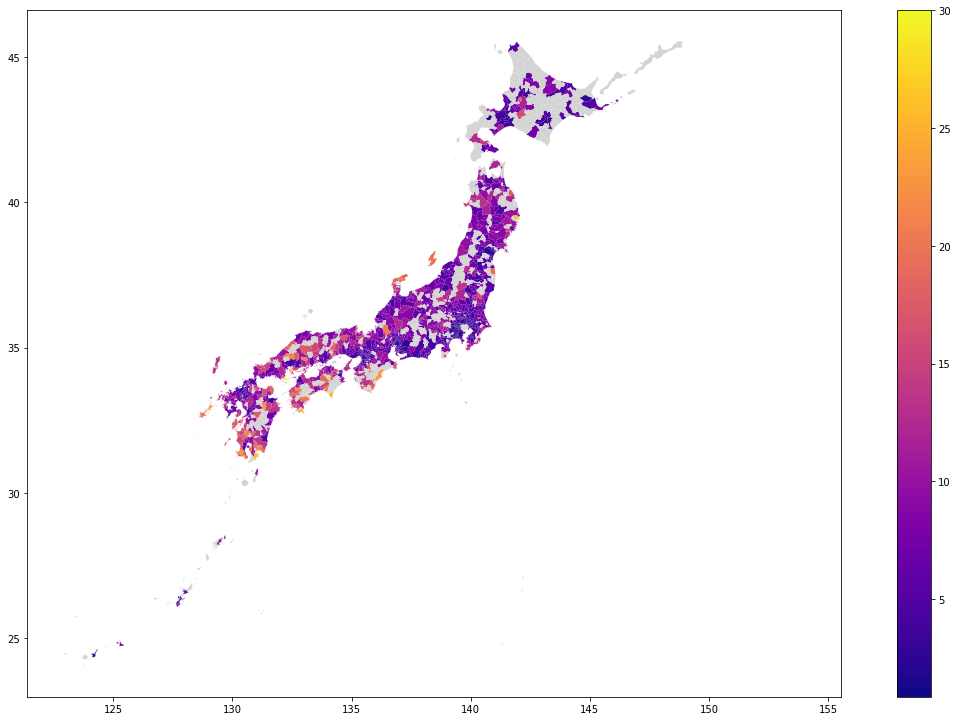

In [77]:
f = plt.figure()
f.set_size_inches(20,12)

ax1 = f.add_subplot()
df_final.plot(column='empty_homes_ratio', legend=True, cmap='plasma', figsize=(20, 12), ax=ax1, missing_kwds={'color': 'lightgrey'})

f.subplots_adjust(top=0.92)

A significant number of municipalities in Inland areas are not 

## Methodology

There 
Here, classification will be done based to the size of the dataset 

In [78]:
# Cluster analysis
columns = ["empty_homes_ratio", "population_change_rate", "proportion_elderly_pop", "proportion_public_assistance", "employment_rate", "business_change_rate", "house_distribution_ratio", "proportion_owned", "proportion_old_housing", "proportion_new_housing", "proportion_detached", "proportion_apartment"]
df_raw = df_final[columns].dropna()

In [79]:
df_raw

,empty_homes_ratio,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,
01202,7.336901,-4.710401,32.400383,14.864410,94.703095,-1.847541,0.995701,57.156823,21.409369,2.517312,55.454175,39.437882
01203,7.963507,-7.582924,37.164826,14.431808,94.337923,-2.029368,0.988323,67.704426,29.726182,1.987997,61.027757,34.452363
01204,4.155171,-2.157911,31.770535,13.060137,95.191839,-1.505205,0.990547,58.564025,24.573379,3.653141,59.265580,37.688029
01205,8.385915,-6.316179,34.105630,12.404407,95.013123,-5.325704,0.993314,55.447519,35.776614,3.290950,57.566692,39.815507
01206,5.463961,-3.547516,30.352632,14.067797,95.473797,-0.346460,0.994558,56.920781,23.678647,2.611615,57.679393,38.216640
...,...,...,...,...,...,...,...,...,...,...,...,...
43100,4.667219,0.864292,24.172551,6.410974,95.439706,2.107485,0.993732,50.425733,16.682435,5.707979,47.650583,50.362662
14150,2.973978,0.455043,23.931351,7.680371,95.659489,-0.515900,0.992694,58.784000,15.520000,3.456000,45.568000,51.712000
28100,4.267772,-0.448647,27.094696,9.877724,94.906006,1.719828,0.995918,58.224986,19.954777,3.533070,35.924251,61.871114


In [80]:
df_cluster = df_raw.copy()
rs = RobustScaler()
for c in df_cluster.columns.values:
    df_cluster[c] = rs.fit_transform(df_raw[c].values.reshape(-1,1))

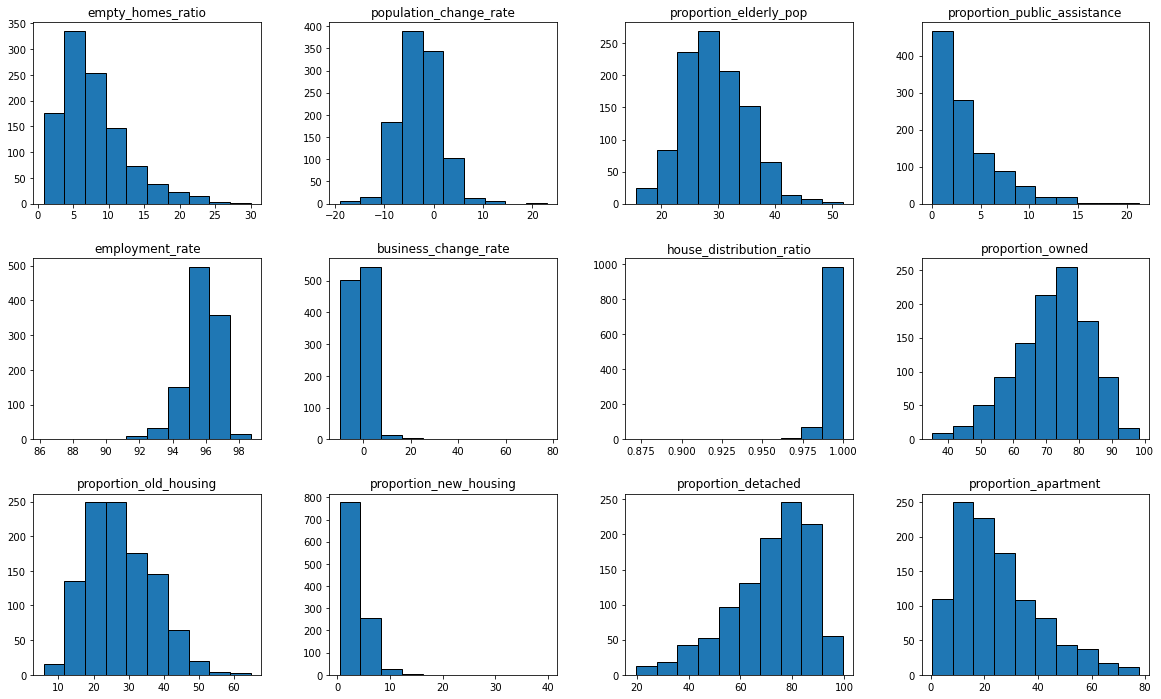

In [81]:
#create histogram for each column in DataFrame
fig, axis = plt.subplots(3, 4, figsize = (20, 12)) 
df.hist(ax=axis, edgecolor='black', grid=False);

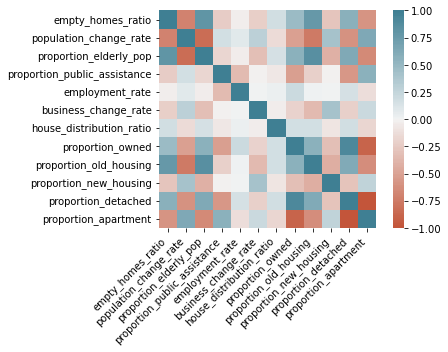

In [82]:
#plotting the heatmap for correlation
ax = sns.heatmap(df_raw.corr(),  
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [83]:
# check skewness of each of the variables
df.skew(axis = 0, skipna = True, numeric_only=True)

empty_homes_ratio               1.214886
population_change_rate          0.358521
proportion_elderly_pop          0.360443
proportion_public_assistance    1.427543
employment_rate                -1.762995
business_change_rate            8.492574
house_distribution_ratio       -8.844073
proportion_owned               -0.461617
proportion_old_housing          0.493067
proportion_new_housing          5.646877
proportion_detached            -0.884957
proportion_apartment            0.964517
dtype: float64

In [84]:
df_cluster 

,empty_homes_ratio,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,
01202,0.078343,-0.314683,0.468125,2.850544,-0.936665,-0.213984,-0.007381,-1.075803,-0.362085,-0.476597,-0.933078,0.889243
01203,0.187732,-0.818702,1.084974,2.750146,-1.230662,-0.268104,-1.316780,-0.367363,0.235837,-0.745850,-0.667308,0.643756
01204,-0.477107,0.133182,0.386579,2.431808,-0.543181,-0.112089,-0.922091,-0.981287,-0.134614,0.101180,-0.751336,0.803080
01205,0.261474,-0.596436,0.688902,2.279625,-0.687064,-1.249240,-0.431049,-1.190610,0.670822,-0.083061,-0.832345,0.907838
01206,-0.248625,-0.110641,0.203004,2.665666,-0.316179,0.232805,-0.210228,-1.091657,-0.198939,-0.428626,-0.826971,0.829109
...,...,...,...,...,...,...,...,...,...,...,...,...
43100,-0.387716,0.663464,-0.597125,0.888666,-0.343626,0.963209,-0.356717,-1.527903,-0.701919,1.146440,-1.305182,1.427182
14150,-0.683313,0.591657,-0.628353,1.183269,-0.166680,0.182372,-0.541032,-0.966512,-0.785490,0.000897,-1.404487,1.493623
28100,-0.457450,0.433093,-0.218798,1.693232,-0.773303,0.847824,0.031222,-1.004059,-0.466660,0.040101,-1.864337,1.993860


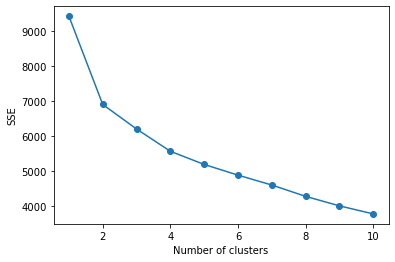

In [85]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_cluster)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [86]:
x = []
y = []

# For resolutions of 'k' in the range 2..40
for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(df_cluster)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(df_cluster, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

.......................................

In [87]:
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")


Largest silhouette score was 0.2707 for k=2


In [88]:
# separate the independent and dependent variables
X = df_raw.drop('empty_homes_ratio', axis=1).values
Y = df_raw.loc[:,['empty_homes_ratio']].values

In [89]:
X = RobustScaler().fit_transform(X)

In [90]:
from sklearn.decomposition import PCA
rand_st_int = 10 
pca = PCA(random_state=rand_st_int) # making the result reproducable 
# fit the components
X_new_components = pca.fit_transform(X)

In [91]:
list_var_X = df_raw.columns.tolist()
list_var_X.remove('empty_homes_ratio')

In [92]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var_X) # the list_var_X is used as the column names
df_PrincipleComp

,population_change_rate,proportion_elderly_pop,proportion_public_assistance,employment_rate,business_change_rate,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
0,0.320807,-0.326801,0.175260,-0.052758,0.351141,-0.153484,-0.335913,-0.307714,0.383305,-0.353188,0.361575
1,-0.003106,0.004371,-0.386376,0.234783,0.617879,0.178383,0.246580,0.000578,0.427636,0.258939,-0.266914
2,0.001589,0.000946,-0.179687,0.147123,-0.055967,-0.953542,0.102086,0.002639,0.051968,0.101876,-0.100899
3,-0.295943,0.252927,0.261209,-0.674718,0.502839,-0.180872,-0.013264,0.167684,-0.088527,0.022752,-0.052536
4,-0.082555,0.078878,-0.012622,-0.382361,-0.482411,0.033389,-0.011238,0.052027,0.763402,0.075105,-0.124551
5,0.366728,-0.394214,-0.359994,-0.543064,-0.067937,0.030815,0.205738,-0.338484,-0.258596,0.180616,-0.153731
6,-0.195149,0.148396,-0.761237,-0.128052,-0.003460,0.021218,-0.420738,0.177498,-0.068952,-0.270358,0.239125
7,0.710108,0.175623,-0.001938,-0.069658,0.029988,-0.010246,0.114602,0.660425,0.018056,-0.062799,0.074024
8,-0.084354,0.247520,-0.100345,-0.048974,-0.026236,0.005793,0.727548,-0.193695,0.058091,-0.352127,0.473517
9,0.344558,0.743080,-0.013064,0.016350,-0.002694,0.003308,-0.215751,-0.504690,-0.032991,0.073394,-0.144639


In [93]:
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)
# first component is much more important than the second component

Explained variance ratio of each component:
[0.38609575 0.18059632 0.12991033 0.10363164 0.08576595 0.05369712
 0.03034679 0.01486361 0.00738839 0.00712001 0.0005841 ]


In [94]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)
# Three PCs may be used (larger than 1)

Eigenvalues of each component:
[3.19488204 1.49440633 1.07498771 0.85753567 0.70969985 0.44433529
 0.25111497 0.12299403 0.06113773 0.058917   0.00483333]


<AxesSubplot:xlabel='PC'>

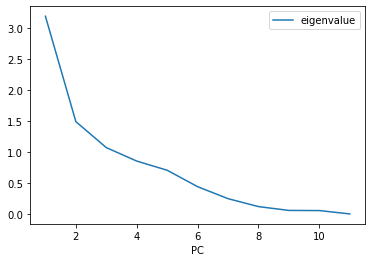

In [95]:
df_pca = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})
df_pca.plot.line(x = 'PC', y = 'eigenvalue')

In [96]:
df_pca

,eigenvalue,PC
0,3.194882,1
1,1.494406,2
2,1.074988,3
3,0.857536,4
4,0.709700,5
5,0.444335,6
6,0.251115,7
7,0.122994,8
8,0.061138,9
9,0.058917,10


In [97]:
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

The histograms and the skewness values for each of the variables demonstrate how the variables demonstrate diffent distribution patterns. Variables such as the change rate for population (<code>population_change_rate</code>), the proportion of elderly population (<code>proportion_elderly_pop</code>), the proportion of owned housing (<code>proportion_owned</code>), and the proportion of old housing (<code>proportion_old_housing</code>). 

In [ ]:
Clustering 

In [ ]:
Spatial cross validation

In [ ]:
clustering 

## Results

## Discussion

limitations of the analysis 
- collection of the data - 

## References